# Exploratory Analysis: Life Expectancy Prediction

## Research Question
Which socioeconomic and health-system indicators most strongly predict national life expectancy, and how do different feature representations and modeling strategies affect predictive performance?

This notebook performs:
1. Dataset description and feasibility assessment.
2. Initial exploratory data analysis aligned with the modeling objective.


In [10]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', context='notebook')

DATA_DIR = Path('../Assets/cleaner_exports')
RAW_PATH = DATA_DIR / 'health_panel_2000_2021.csv'
CLEAN_PATH = DATA_DIR / 'health_panel_ml_clean.csv'
NUMERIC_PATH = DATA_DIR / 'health_panel_ml_numeric.csv'
OUT_DIR = DATA_DIR
IMG_DIR = Path('../Images')
IMG_DIR.mkdir(parents=True, exist_ok=True)

for p in [RAW_PATH, CLEAN_PATH, NUMERIC_PATH]:
    if not p.exists():
        raise FileNotFoundError(f'Missing required input: {p.resolve()}')

print('Using data from:', DATA_DIR.resolve())


Using data from: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports


## 1) Load Datasets

In [11]:
raw = pd.read_csv(RAW_PATH)
clean = pd.read_csv(CLEAN_PATH)
num = pd.read_csv(NUMERIC_PATH)

print('Raw panel shape      :', raw.shape)
print('Clean ML shape       :', clean.shape)
print('Numeric ML shape     :', num.shape)
print('Countries (clean)    :', clean['ISO3'].nunique())
print('Year range (clean)   :', int(clean['Year'].min()), '-', int(clean['Year'].max()))
print('Rows per country avg :', round(len(clean) / clean['ISO3'].nunique(), 2))


Raw panel shape      : (4532, 17)
Clean ML shape       : (4224, 16)
Numeric ML shape     : (4224, 19)
Countries (clean)    : 192
Year range (clean)   : 2000 - 2021
Rows per country avg : 22.0


## 2) Dataset Description

In [12]:
column_info = {
    'Country': ('identifier', 'Canonical country name'),
    'ISO3': ('identifier', 'Country ISO3 code'),
    'Year': ('time index', 'Observation year'),
    'life_expectancy': ('target', 'Life expectancy at birth (years)'),
    'adult_mortality_15_60': ('predictor', 'Adult mortality rate 15-60'),
    'alcohol_per_capita_15plus': ('predictor', 'Alcohol use per capita (15+)'),
    'che_pct_gdp': ('predictor', 'Current health expenditure (% GDP)'),
    'hepb3_coverage_pct': ('predictor', 'HepB3 immunization coverage'),
    'pol3_coverage_pct': ('predictor', 'Polio immunization coverage'),
    'dtp3_coverage_pct': ('predictor', 'DTP3 immunization coverage'),
    'gdp_per_capita_2015usd': ('predictor', 'GDP per capita (constant 2015 USD)'),
    'overweight_adults_pct': ('predictor', 'Overweight prevalence in adults'),
    'underweight_adults_pct': ('predictor', 'Underweight prevalence in adults'),
    'thinness_children_adolescents_pct': ('predictor', 'Thinness prevalence in children/adolescents'),
    'infant_deaths': ('predictor', 'Number of infant deaths'),
    'u5_mortality_rate': ('predictor', 'Under-five mortality rate'),
}

dataset_profile = pd.DataFrame([
    {
        'column': c,
        'role': column_info.get(c, ('unknown', 'n/a'))[0],
        'description': column_info.get(c, ('unknown', 'n/a'))[1],
        'dtype': str(clean[c].dtype),
        'missing_pct': round(clean[c].isna().mean() * 100, 3),
        'n_unique': int(clean[c].nunique(dropna=True)),
    }
    for c in clean.columns
])

dataset_profile.to_csv(OUT_DIR / 'exploratory_dataset_profile.csv', index=False)
dataset_profile


,column,role,description,dtype,missing_pct,n_unique
0,Country,identifier,Canonical country name,str,0.0,192
1,ISO3,identifier,Country ISO3 code,str,0.0,192
2,Year,time index,Observation year,int64,0.0,22
3,life_expectancy,target,Life expectancy at birth (years),float64,0.0,350
4,adult_mortality_15_60,predictor,Adult mortality rate 15-60,float64,0.0,455
5,alcohol_per_capita_15plus,predictor,Alcohol use per capita (15+),float64,0.0,154
6,che_pct_gdp,predictor,Current health expenditure (% GDP),float64,0.0,998
7,hepb3_coverage_pct,predictor,HepB3 immunization coverage,float64,0.0,93
8,pol3_coverage_pct,predictor,Polio immunization coverage,float64,0.0,62
9,dtp3_coverage_pct,predictor,DTP3 immunization coverage,float64,0.0,64


## 3) Feasibility Assessment for Predictive Modeling

In [13]:
id_cols = ['Country', 'ISO3', 'Year']
target_col = 'life_expectancy'
feature_cols = [c for c in clean.columns if c not in id_cols + [target_col]]

# Missingness before/after cleaning
raw_missing = raw.isna().mean().mul(100).sort_values(ascending=False).rename('raw_missing_pct').reset_index()
raw_missing.columns = ['column', 'raw_missing_pct']
raw_missing.to_csv(OUT_DIR / 'exploratory_raw_missingness_pct.csv', index=False)

clean_missing = clean[feature_cols + [target_col]].isna().mean().mul(100).sort_values(ascending=False)

# Correlations with target
corr_with_target = clean[[target_col] + feature_cols].corr(numeric_only=True)[target_col].drop(target_col)
corr_tbl = corr_with_target.rename('pearson_corr').to_frame()
corr_tbl['abs_pearson_corr'] = corr_tbl['pearson_corr'].abs()
corr_tbl = corr_tbl.sort_values('abs_pearson_corr', ascending=False)
corr_tbl.reset_index().rename(columns={'index': 'feature'}).to_csv(OUT_DIR / 'exploratory_feature_target_correlations.csv', index=False)

# Multicollinearity quick scan (high pairwise feature correlations)
feat_corr = clean[feature_cols].corr(numeric_only=True)
upper = feat_corr.where(np.triu(np.ones(feat_corr.shape), k=1).astype(bool))
high_corr_pairs = (
    upper.stack()
    .rename('pearson_corr')
    .reset_index()
    .rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2'})
)
high_corr_pairs = high_corr_pairs.loc[high_corr_pairs['pearson_corr'].abs() >= 0.85].copy()
high_corr_pairs['abs_pearson_corr'] = high_corr_pairs['pearson_corr'].abs()
high_corr_pairs = high_corr_pairs.sort_values('abs_pearson_corr', ascending=False)
high_corr_pairs.to_csv(OUT_DIR / 'exploratory_high_feature_correlations.csv', index=False)

# Panel coverage and signal checks
country_count = clean['ISO3'].nunique()
year_count = clean['Year'].nunique()
n_rows = len(clean)
n_features = len(feature_cols)
rows_per_feature = n_rows / n_features

yearly_target = clean.groupby('Year')[target_col].agg(['mean', 'std', 'min', 'max']).reset_index()
yearly_target.to_csv(OUT_DIR / 'exploratory_target_by_year.csv', index=False)

country_target = clean.groupby(['ISO3', 'Country'])[target_col].mean().reset_index(name='avg_life_expectancy')
country_target = country_target.sort_values('avg_life_expectancy', ascending=False)
country_target.to_csv(OUT_DIR / 'exploratory_country_avg_life_expectancy.csv', index=False)

feasibility = pd.DataFrame([
    {'check': 'rows', 'value': n_rows, 'interpretation': 'Sample size for model training/evaluation'},
    {'check': 'countries', 'value': country_count, 'interpretation': 'Cross-country coverage'},
    {'check': 'years', 'value': year_count, 'interpretation': 'Temporal coverage'},
    {'check': 'predictor_count', 'value': n_features, 'interpretation': 'Number of candidate predictors'},
    {'check': 'rows_per_predictor', 'value': round(rows_per_feature, 2), 'interpretation': 'Higher is generally better for stable estimation'},
    {'check': 'target_std', 'value': round(float(clean[target_col].std()), 3), 'interpretation': 'Target variability available to learn'},
    {'check': 'mean_raw_missing_pct', 'value': round(float(raw.isna().mean().mean() * 100), 3), 'interpretation': 'Average missingness in uncleaned merged panel'},
    {'check': 'mean_clean_missing_pct', 'value': round(float(clean[feature_cols + [target_col]].isna().mean().mean() * 100), 3), 'interpretation': 'Average missingness after cleaning'},
    {'check': 'high_corr_feature_pairs_abs_ge_0.85', 'value': int(len(high_corr_pairs)), 'interpretation': 'Potential multicollinearity risk pairs'},
])

feasibility.to_csv(OUT_DIR / 'exploratory_feasibility_assessment.csv', index=False)

print('Top feature-target correlations:')
display(corr_tbl.head(10))
print('Feasibility summary:')
display(feasibility)


Top feature-target correlations:


,pearson_corr,abs_pearson_corr
adult_mortality_15_60,-0.940987,0.940987
u5_mortality_rate,-0.887208,0.887208
underweight_adults_pct,-0.621548,0.621548
pol3_coverage_pct,0.609013,0.609013
dtp3_coverage_pct,0.606667,0.606667
gdp_per_capita_2015usd,0.603546,0.603546
overweight_adults_pct,0.597281,0.597281
thinness_children_adolescents_pct,-0.472071,0.472071
alcohol_per_capita_15plus,0.373189,0.373189
che_pct_gdp,0.278247,0.278247


Feasibility summary:


,check,value,interpretation
0,rows,4224.000,Sample size for model training/evaluation
1,countries,192.000,Cross-country coverage
2,years,22.000,Temporal coverage
3,predictor_count,12.000,Number of candidate predictors
4,rows_per_predictor,352.000,Higher is generally better for stable estimation
5,target_std,8.379,Target variability available to learn
6,mean_raw_missing_pct,9.562,Average missingness in uncleaned merged panel
7,mean_clean_missing_pct,0.000,Average missingness after cleaning
8,high_corr_feature_pairs_abs_ge_0.85,2.000,Potential multicollinearity risk pairs


## 4) Initial Exploratory Analysis

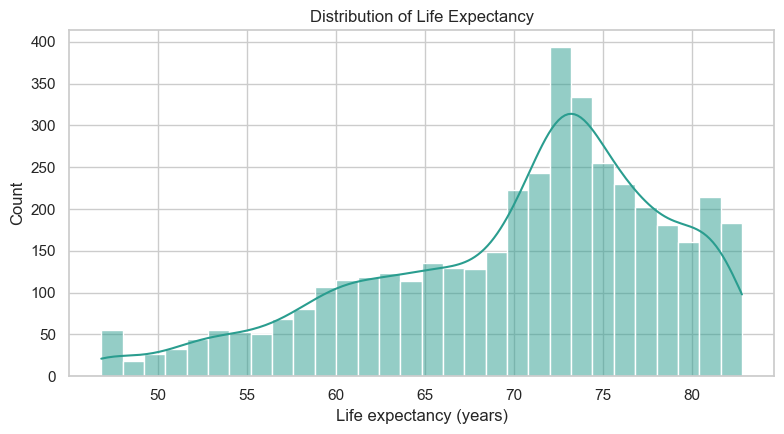

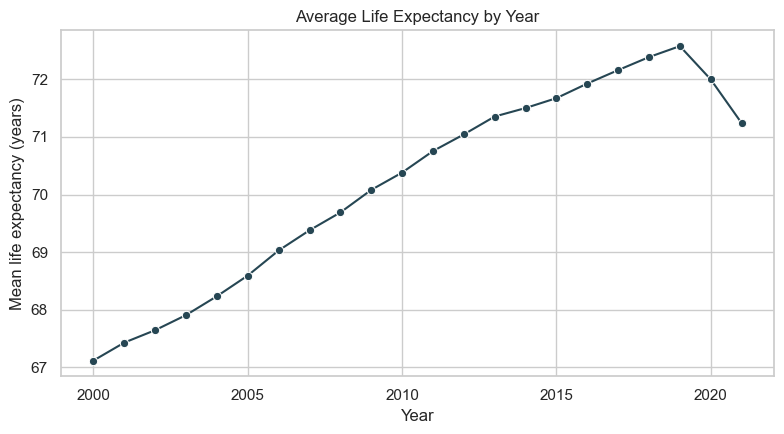

In [14]:
# 4.1 Target distribution
fig, ax = plt.subplots(figsize=(8, 4.5))
sns.histplot(clean['life_expectancy'], bins=30, kde=True, color='#2a9d8f', ax=ax)
ax.set_title('Distribution of Life Expectancy')
ax.set_xlabel('Life expectancy (years)')
plt.tight_layout()
fig.savefig(IMG_DIR / 'exploratory_life_expectancy_distribution.png', dpi=150)
plt.show()

# 4.2 Mean target over time
trend = clean.groupby('Year', as_index=False)['life_expectancy'].mean()
fig, ax = plt.subplots(figsize=(8, 4.5))
sns.lineplot(data=trend, x='Year', y='life_expectancy', marker='o', color='#264653', ax=ax)
ax.set_title('Average Life Expectancy by Year')
ax.set_ylabel('Mean life expectancy (years)')
plt.tight_layout()
fig.savefig(IMG_DIR / 'exploratory_life_expectancy_trend.png', dpi=150)
plt.show()


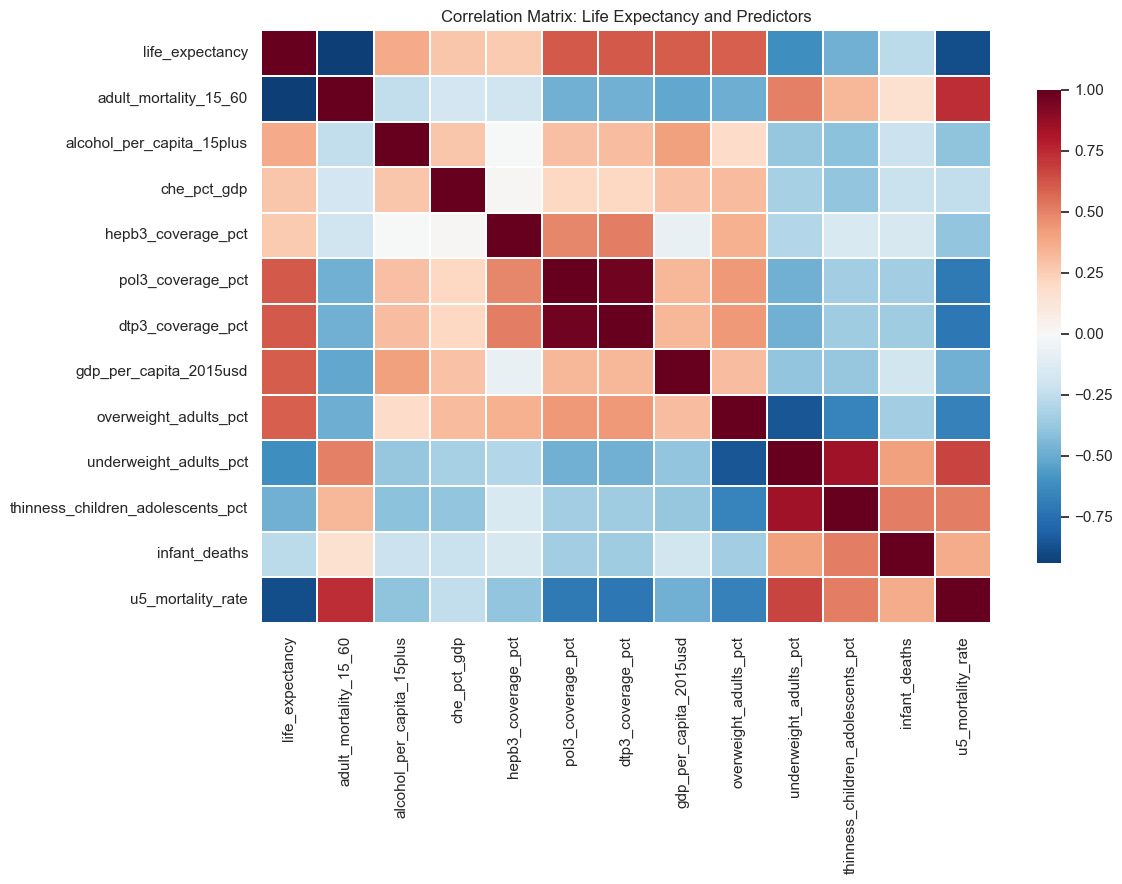

In [15]:
# 4.3 Correlation heatmap among target + predictors
corr_mat = clean[['life_expectancy'] + feature_cols].corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, cmap='RdBu_r', center=0, linewidths=0.3, square=False, cbar_kws={'shrink': 0.8}, ax=ax)
ax.set_title('Correlation Matrix: Life Expectancy and Predictors')
plt.tight_layout()
fig.savefig(IMG_DIR / 'exploratory_correlation_heatmap.png', dpi=150)
plt.show()


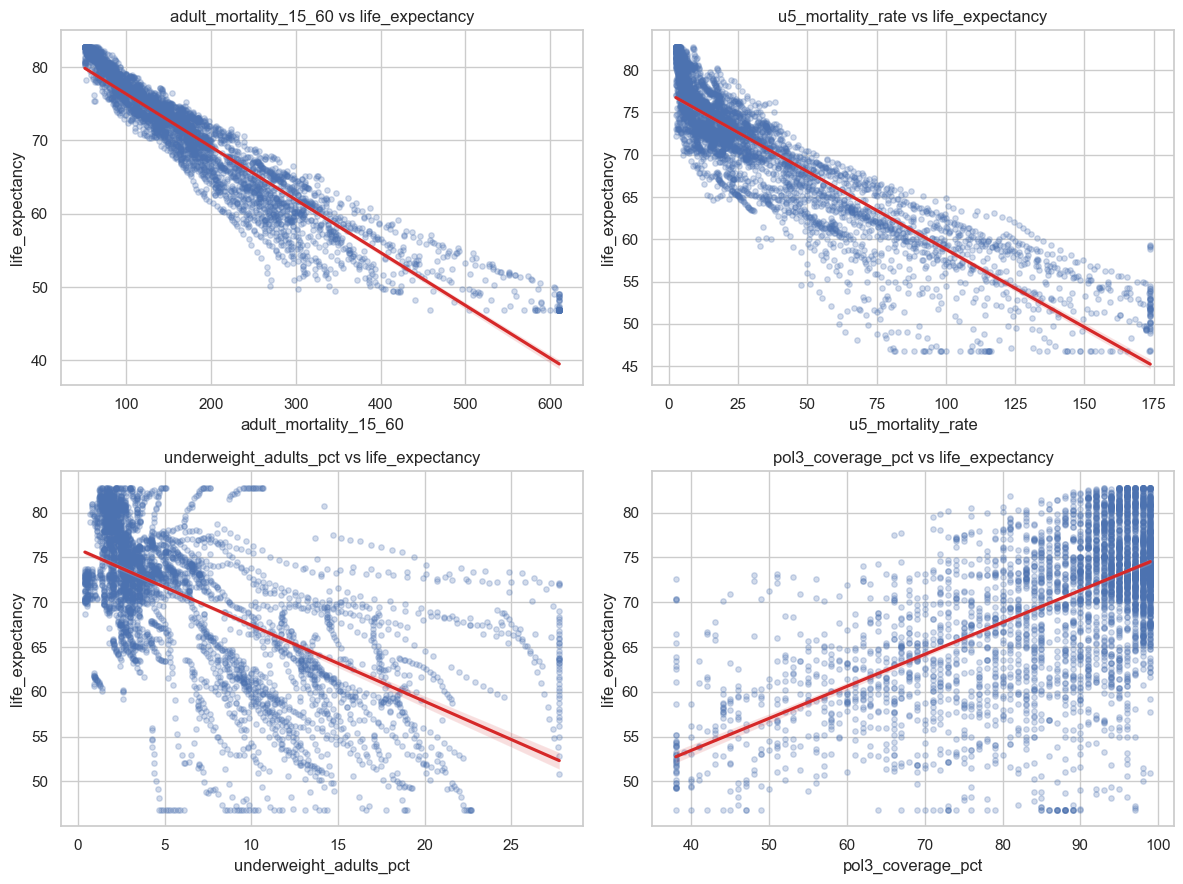

Top predictors by |Pearson correlation|:


,pearson_corr,abs_pearson_corr
adult_mortality_15_60,-0.940987,0.940987
u5_mortality_rate,-0.887208,0.887208
underweight_adults_pct,-0.621548,0.621548
pol3_coverage_pct,0.609013,0.609013
dtp3_coverage_pct,0.606667,0.606667
gdp_per_capita_2015usd,0.603546,0.603546
overweight_adults_pct,0.597281,0.597281
thinness_children_adolescents_pct,-0.472071,0.472071
alcohol_per_capita_15plus,0.373189,0.373189
che_pct_gdp,0.278247,0.278247


In [16]:
# 4.4 Top predictors vs target
N_TOP = 4
top_feats = corr_tbl.head(N_TOP).index.tolist()

fig, axes = plt.subplots(2, 2, figsize=(12, 9))
axes = axes.flatten()

for i, feat in enumerate(top_feats):
    sns.regplot(data=clean, x=feat, y='life_expectancy', scatter_kws={'alpha': 0.25, 's': 15}, line_kws={'color': '#d62828'}, ax=axes[i])
    axes[i].set_title(f'{feat} vs life_expectancy')

for j in range(len(top_feats), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
fig.savefig(IMG_DIR / 'exploratory_top_predictors_vs_target.png', dpi=150)
plt.show()

print('Top predictors by |Pearson correlation|:')
display(corr_tbl.head(10))


In [17]:
# 4.5 Country summary extremes for context
country_summary = (
    clean.groupby(['ISO3', 'Country'], as_index=False)
         .agg(
             avg_life_expectancy=('life_expectancy', 'mean'),
             avg_gdp_per_capita=('gdp_per_capita_2015usd', 'mean'),
             avg_u5_mortality=('u5_mortality_rate', 'mean'),
             avg_infant_deaths=('infant_deaths', 'mean')
         )
)

country_summary_sorted = country_summary.sort_values('avg_life_expectancy', ascending=False)
country_summary_sorted.to_csv(OUT_DIR / 'exploratory_country_summary.csv', index=False)

print('Top 10 countries by average life expectancy:')
display(country_summary_sorted.head(10))

print('Bottom 10 countries by average life expectancy:')
display(country_summary_sorted.tail(10))


Top 10 countries by average life expectancy:


,ISO3,Country,avg_life_expectancy,avg_gdp_per_capita,avg_u5_mortality,avg_infant_deaths
87,JPN,Japan,82.577273,33692.127383,3.295455,2526.727273
30,CHE,Switzerland,81.863636,76692.010515,4.636364,312.909091
8,AUS,Australia,81.695455,53869.838628,4.781818,1133.318182
82,ISL,Iceland,81.531818,51434.205656,2.927273,9.818182
84,ITA,Italy,81.486364,32128.415450,4.000000,1766.818182
152,SGP,Singapore,81.459091,49112.897947,2.900000,104.272727
54,ESP,Spain,81.345455,26029.910179,4.000000,1406.500000
163,SWE,Sweden,81.209091,48333.060571,3.195455,277.045455
59,FRA,France,81.027273,35895.099879,4.445455,2557.727273
104,LUX,Luxembourg,81.027273,77559.613939,3.104545,14.590909


Bottom 10 countries by average life expectancy:


,ISO3,Country,avg_life_expectancy,avg_gdp_per_capita,avg_u5_mortality,avg_infant_deaths
190,ZMB,Zambia,55.739500,1116.028892,84.750000,28546.818182
167,TCD,Chad,55.600000,867.338203,145.000000,47077.090909
154,SLE,Sierra Leone,55.331818,920.740020,148.540909,20817.000000
67,GNB,Guinea-Bissau,55.131818,631.913586,116.977273,3976.227273
118,MOZ,Mozambique,54.209091,493.683306,100.477273,62368.318182
191,ZWE,Zimbabwe,52.502773,1274.295790,75.509091,27441.318182
156,SOM,Somalia,51.369227,380.156252,154.668182,57679.454545
164,SWZ,Eswatini,49.688773,3068.285874,81.118182,2049.045455
28,CAF,Central African Republic,49.252773,430.824214,146.427273,18140.500000
102,LSO,Lesotho,48.751727,960.782222,91.500000,4266.090909


## 5) Practical Takeaways for Modeling

- The cleaned panel has broad country-year coverage with multiple predictive signals.
- Strong univariate associations are expected for mortality and early-life health indicators.
- Some predictor pairs are highly correlated, so regularization or feature selection should be used in modeling.
- Both raw and transformed representations (e.g., logs already available in `health_panel_ml_numeric.csv`) are feasible for downstream model comparison.

CSV outputs are saved in `../Assets/cleaner_exports/`, and image outputs are saved in `../Images/`.


## 6) Temporal Train-Test Split


In [18]:
# 6) Temporal Train-Test Split (chronological holdout)
TARGET_COL = 'life_expectancy'
ID_COLS = ['Country', 'ISO3', 'Year']
TRAIN_END_YEAR = 2017
TEST_START_YEAR = 2018

model_df = num.copy().sort_values(['Year', 'ISO3']).reset_index(drop=True)

train_df = model_df[model_df['Year'] <= TRAIN_END_YEAR].copy()
test_df = model_df[model_df['Year'] >= TEST_START_YEAR].copy()

if train_df.empty or test_df.empty:
    raise ValueError('Temporal split produced an empty train or test set.')

if train_df['Year'].max() >= test_df['Year'].min():
    raise ValueError('Temporal leakage risk: train years overlap with test years.')

if TARGET_COL not in model_df.columns:
    raise ValueError(f"Missing target column: {TARGET_COL}")

feature_cols = [c for c in model_df.columns if c not in ID_COLS + [TARGET_COL]]

X_train = train_df[feature_cols].copy()
y_train = train_df[TARGET_COL].copy()
X_test = test_df[feature_cols].copy()
y_test = test_df[TARGET_COL].copy()

print('Temporal split complete')
print(f"Train years: {int(train_df['Year'].min())}-{int(train_df['Year'].max())} | rows={len(train_df)} | countries={train_df['ISO3'].nunique()}")
print(f"Test years : {int(test_df['Year'].min())}-{int(test_df['Year'].max())} | rows={len(test_df)} | countries={test_df['ISO3'].nunique()}")
print(f'Feature count: {len(feature_cols)}')

train_out = OUT_DIR / 'train_temporal_2000_2017.csv'
test_out = OUT_DIR / 'test_temporal_2018_2021.csv'
summary_out = OUT_DIR / 'temporal_split_summary.csv'

train_df.to_csv(train_out, index=False)
test_df.to_csv(test_out, index=False)

split_summary = pd.DataFrame([
    {
        'split': 'train',
        'rows': len(train_df),
        'countries': train_df['ISO3'].nunique(),
        'year_min': int(train_df['Year'].min()),
        'year_max': int(train_df['Year'].max()),
        'feature_count': len(feature_cols),
    },
    {
        'split': 'test',
        'rows': len(test_df),
        'countries': test_df['ISO3'].nunique(),
        'year_min': int(test_df['Year'].min()),
        'year_max': int(test_df['Year'].max()),
        'feature_count': len(feature_cols),
    },
])

split_summary.to_csv(summary_out, index=False)

display(split_summary)
print('Saved:', train_out.resolve())
print('Saved:', test_out.resolve())
print('Saved:', summary_out.resolve())



Temporal split complete
Train years: 2000-2017 | rows=3456 | countries=192
Test years : 2018-2021 | rows=768 | countries=192
Feature count: 15


,split,rows,countries,year_min,year_max,feature_count
0,train,3456,192,2000,2017,15
1,test,768,192,2018,2021,15


Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports/train_temporal_2000_2017.csv
Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports/test_temporal_2018_2021.csv
Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports/temporal_split_summary.csv
